In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def generate_vortex_flow(size=224, strength=1.0, center=None):
    """Generate a vortex (rotational) flow field"""
    if center is None:
        center = (size//2, size//2)
    
    y, x = np.mgrid[:size, :size]
    x = x - center[0]
    y = y - center[1]
    
    # Distance from center (add small epsilon to avoid division by zero)
    r = np.sqrt(x**2 + y**2) + 1e-6
    
    # Normalize by the size to control the strength
    r_norm = r / size
    
    # Compute tangential components (counter-clockwise vortex)
    u = -strength * y / r_norm
    v = strength * x / r_norm
    
    # Normalize the flow to have consistent magnitude
    magnitude = np.sqrt(u**2 + v**2)
    max_mag = np.max(magnitude)
    u = u / max_mag
    v = v / max_mag
    
    return np.stack([u, v], axis=-1)

def generate_sink_flow(size=224, strength=1.0, center=None):
    """Generate a sink (inward) flow field"""
    if center is None:
        center = (size//2, size//2)
    
    y, x = np.mgrid[:size, :size]
    x = x - center[0]
    y = y - center[1]
    
    # Distance from center (add small epsilon to avoid division by zero)
    r = np.sqrt(x**2 + y**2) + 1e-6
    
    # Normalize and get direction
    magnitude = r / size
    
    # Inward flow (negative for sink, positive for source)
    u = -strength * x / magnitude
    v = -strength * y / magnitude
    
    # Normalize to unit magnitude
    magnitude = np.sqrt(u**2 + v**2)
    max_mag = np.max(magnitude)
    u = u / max_mag
    v = v / max_mag
    
    return np.stack([u, v], axis=-1)

def generate_uniform_flow(size=224, angle=45):
    """Generate a uniform flow field with given angle in degrees"""
    angle_rad = np.radians(angle)
    u = np.cos(angle_rad) * np.ones((size, size))
    v = np.sin(angle_rad) * np.ones((size, size))
    
    return np.stack([u, v], axis=-1)

def generate_complex_flow(size=224):
    """Combine multiple flow fields for a more complex pattern"""
    # Create a vortex
    vortex1 = generate_vortex_flow(size, strength=1.0, center=(size//3, size//3))
    vortex2 = generate_vortex_flow(size, strength=-0.7, center=(2*size//3, 2*size//3))
    
    # Create a sink
    sink = generate_sink_flow(size, strength=0.5, center=(2*size//3, size//3))
    
    # Create a uniform flow
    uniform = generate_uniform_flow(size, angle=30)
    
    # Combine the flows with weights
    flow = 0.4 * vortex1 + 0.3 * vortex2 + 0.2 * sink + 0.1 * uniform
    
    # Normalize
    magnitude = np.sqrt(flow[..., 0]**2 + flow[..., 1]**2)
    max_mag = np.max(magnitude)
    flow = flow / max_mag
    
    return flow

In [3]:
def plot_flow_field(flow, title="Flow Field", density=20):
    """Visualize a flow field using matplotlib"""
    plt.figure(figsize=(10, 10))
    
    # Create a custom colormap for the background (magnitude)
    colors = [(0, 0, 0.5), (0, 0.5, 1), (1, 1, 1), (1, 0.5, 0), (0.5, 0, 0)]
    cmap = LinearSegmentedColormap.from_list('flow_cmap', colors, N=100)
    
    # Calculate magnitude for coloring
    u, v = flow[..., 0], flow[..., 1]
    magnitude = np.sqrt(u**2 + v**2)
    
    # Plot the magnitude as a background
    plt.imshow(magnitude, cmap=cmap, origin='lower')
    plt.colorbar(label='Velocity Magnitude')
    
    # Subsample the grid for better visualization
    size = flow.shape[0]
    step = size // density
    y, x = np.mgrid[:size:step, :size:step]
    u_sub = u[::step, ::step]
    v_sub = v[::step, ::step]
    
    # Plot the flow vectors
    plt.quiver(x, y, u_sub, v_sub, 
               angles='xy', scale_units='xy', scale=0.1,
               color='black', width=0.003, 
               headwidth=4, headlength=5, headaxislength=3)
    
    plt.title(title)
    plt.tight_layout()
        
    plt.show()

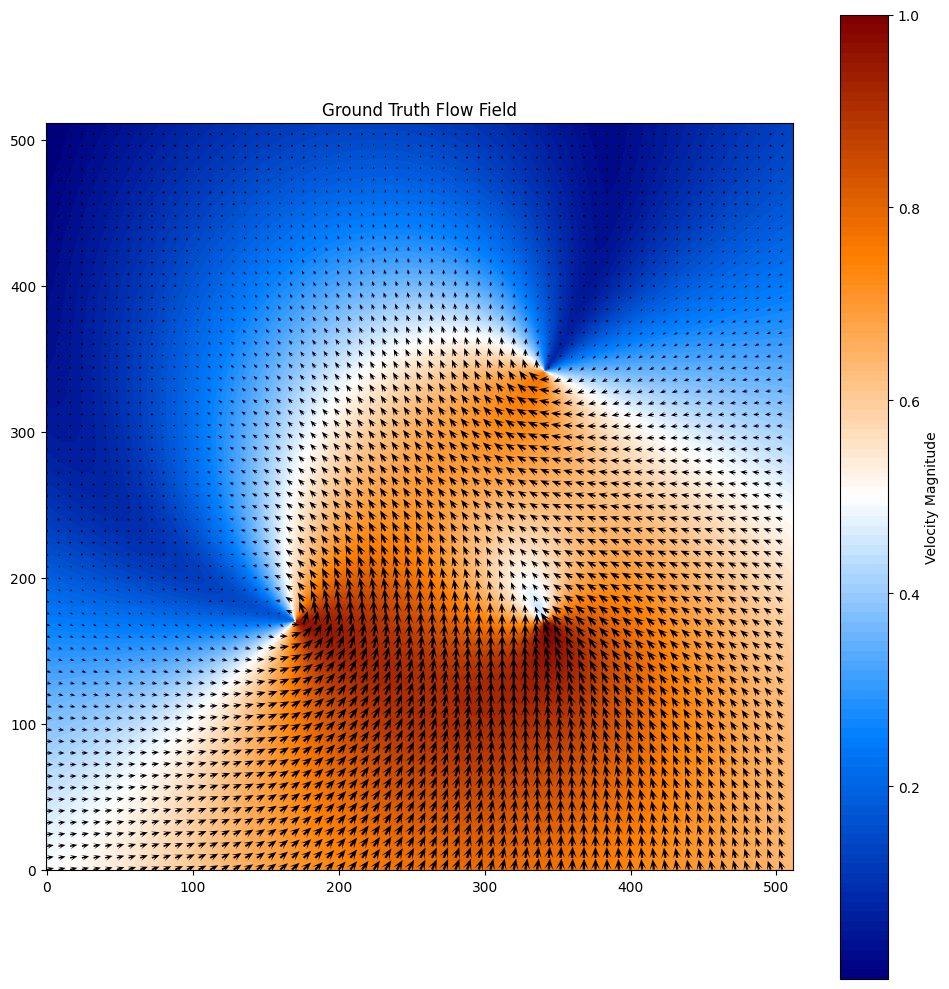

In [5]:
SIZE = 512
flow = generate_complex_flow(SIZE)
plot_flow_field(flow, "Ground Truth Flow Field", SIZE // 8)

In [6]:
class ODE(nn.Module):
	def __init__(self, input_dim, hidden_dims):
		super(ODE, self).__init__()
		dim_list = [input_dim] + list(hidden_dims) + [input_dim]
		layers = []
		for i in range(len(dim_list) - 1):
			layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
			if i < len(dim_list) - 2:
				layers.append(nn.ReLU())
		self.mlp = nn.Sequential(*layers)
	
	def forward(self, x):
		x = self.mlp(x)
		return x

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
flow_tensor = torch.FloatTensor(flow)
flow_tensor = flow_tensor.to(device)

y_coords = torch.arange(SIZE).view(1, SIZE, 1).expand(SIZE, SIZE, 1)
x_coords = torch.arange(SIZE).view(SIZE, 1, 1).expand(SIZE, SIZE, 1)
coordinate_tensor = torch.cat([x_coords, y_coords], dim=2)
coordinate_tensor = coordinate_tensor.float()
coordinate_tensor = coordinate_tensor.to(device)

In [11]:
def fit_flow_field(ode, flow_field, coordinates):
    optim = torch.optim.Adam(ode.parameters(), lr=1e-3, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

    for epoch in range(10000):
        estimated_flow_field = ode(coordinates)

        loss = F.mse_loss(flow_field, estimated_flow_field)
        if epoch == 0 or (epoch < 1000 and (epoch + 1) % 100 == 0) or (epoch + 1) % 1000 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss}')

        optim.zero_grad()
        loss.backward()
        optim.step()
        scheduler.step()

    return estimated_flow_field

In [10]:
ode = ODE(2, (256 for _ in range(3))).to(device)
estimated_flow_tensor = fit_flow_field(ode, flow_tensor, coordinate_tensor)

Epoch 1, Loss: 120.13121032714844
Epoch 100, Loss: 0.06915906071662903
Epoch 200, Loss: 0.061350416392087936
Epoch 300, Loss: 0.05010225251317024
Epoch 400, Loss: 0.036604031920433044
Epoch 500, Loss: 0.030004113912582397
Epoch 600, Loss: 0.023561758920550346
Epoch 700, Loss: 0.019711356610059738
Epoch 800, Loss: 0.017542270943522453
Epoch 900, Loss: 0.01584874838590622
Epoch 1000, Loss: 0.014455117285251617
Epoch 2000, Loss: 0.007616677321493626
Epoch 3000, Loss: 0.006070361007004976
Epoch 4000, Loss: 0.005624179728329182
Epoch 5000, Loss: 0.005425706971436739
Epoch 6000, Loss: 0.005270787049084902
Epoch 7000, Loss: 0.00519093731418252
Epoch 8000, Loss: 0.005155504681169987
Epoch 9000, Loss: 0.005139193031936884
Epoch 10000, Loss: 0.005131730809807777


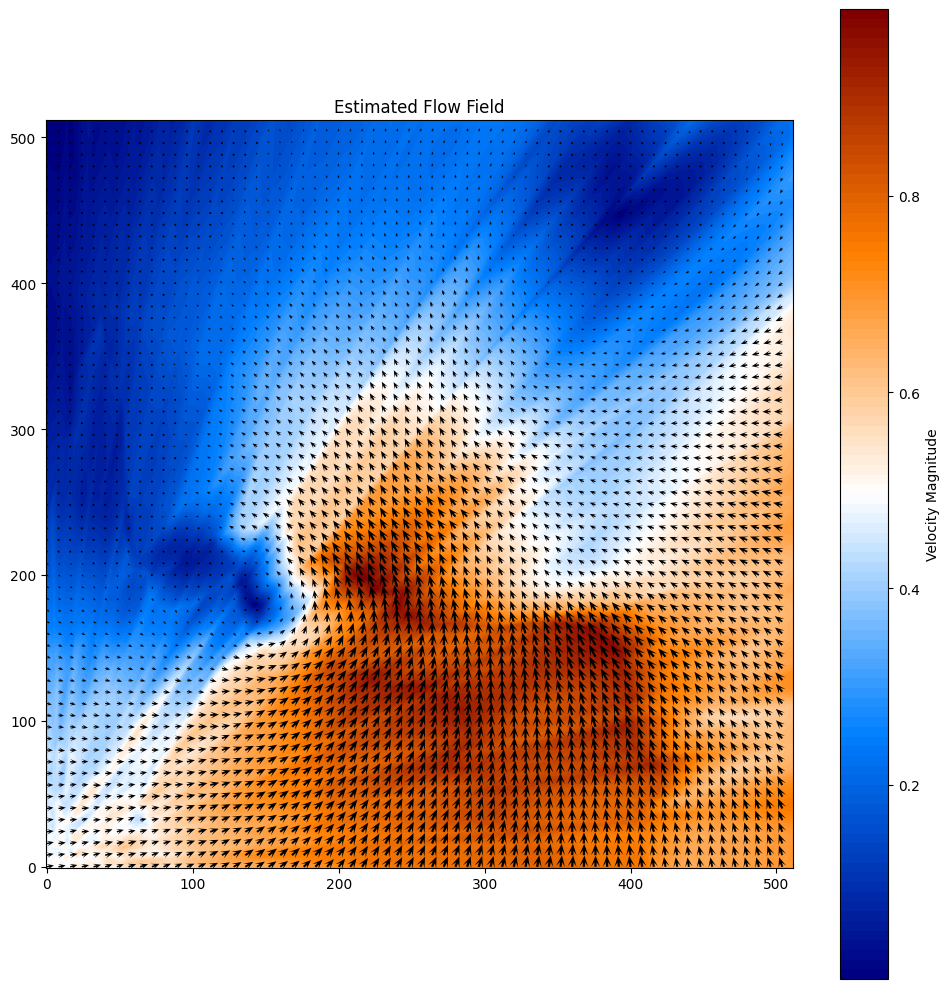

In [12]:
estimated_flow = estimated_flow_tensor.detach().cpu().numpy()
plot_flow_field(estimated_flow, "Estimated Flow Field", SIZE // 8)

In [13]:
import torch
import torch.nn as nn
import numpy as np

class FourierFeatureODE(nn.Module):
    def __init__(self, input_dim, hidden_dims, fourier_scale=10.0, num_fourier_features=10, random_features=False):
        super(FourierFeatureODE, self).__init__()
        
        self.input_dim = input_dim
        self.num_fourier_features = num_fourier_features
        
        self.random_features = random_features
        self.register_buffer('B', torch.randn(input_dim, num_fourier_features) * fourier_scale)
        
        fourier_expanded_dim = input_dim + 2 * num_fourier_features
        dim_list = [fourier_expanded_dim] + list(hidden_dims) + [input_dim]
        layers = []
        for i in range(len(dim_list) - 1):
            layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
            if i < len(dim_list) - 2:
                layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)
    
    # Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains style?
    def compute_random_fourier_features(self, x):
        x_proj = torch.matmul(x, self.B)
        sin_features = torch.sin(2 * np.pi * x_proj)
        cos_features = torch.cos(2 * np.pi * x_proj)
        fourier_features = torch.cat([x, sin_features, cos_features], dim=-1)
        return fourier_features
    
    # NeRF/Transformer style
    def compute_positional_fourier_features(self, x):
        encodings = [x]
        for i in range(self.num_fourier_features // 2):
            freq = 2.0 ** i
            sin_features = torch.sin(freq * x)
            cos_features = torch.cos(freq * x)
            encodings.append(sin_features)
            encodings.append(cos_features)
        return torch.cat(encodings, dim=-1)

    def forward(self, x):
        x_fourier = self.compute_random_fourier_features(x) if self.random_features else self.compute_positional_fourier_features(x)
        output = self.mlp(x_fourier)
        return output

In [14]:
ode = FourierFeatureODE(2, (256 for _ in range(3)), num_fourier_features=126).to(device)
estimated_flow_tensor_ff = fit_flow_field(ode, flow_tensor, coordinate_tensor)

Epoch 1, Loss: 1.3360908031463623
Epoch 100, Loss: 0.017261873930692673
Epoch 200, Loss: 0.004148563370108604
Epoch 300, Loss: 0.0025595270562916994
Epoch 400, Loss: 0.001812448725104332
Epoch 500, Loss: 0.0013847769005224109
Epoch 600, Loss: 0.0011256318539381027
Epoch 700, Loss: 0.0009236524347215891
Epoch 800, Loss: 0.000793398532550782
Epoch 900, Loss: 0.0006991567788645625
Epoch 1000, Loss: 0.0006227493286132812
Epoch 2000, Loss: 0.0003248002612963319
Epoch 3000, Loss: 0.00024332597968168557
Epoch 4000, Loss: 0.0002096342359436676
Epoch 5000, Loss: 0.00019366425112821162
Epoch 6000, Loss: 0.0001856386661529541
Epoch 7000, Loss: 0.0001815581927075982
Epoch 8000, Loss: 0.0001795576827134937
Epoch 9000, Loss: 0.00017861914238892496
Epoch 10000, Loss: 0.00017819700588006526


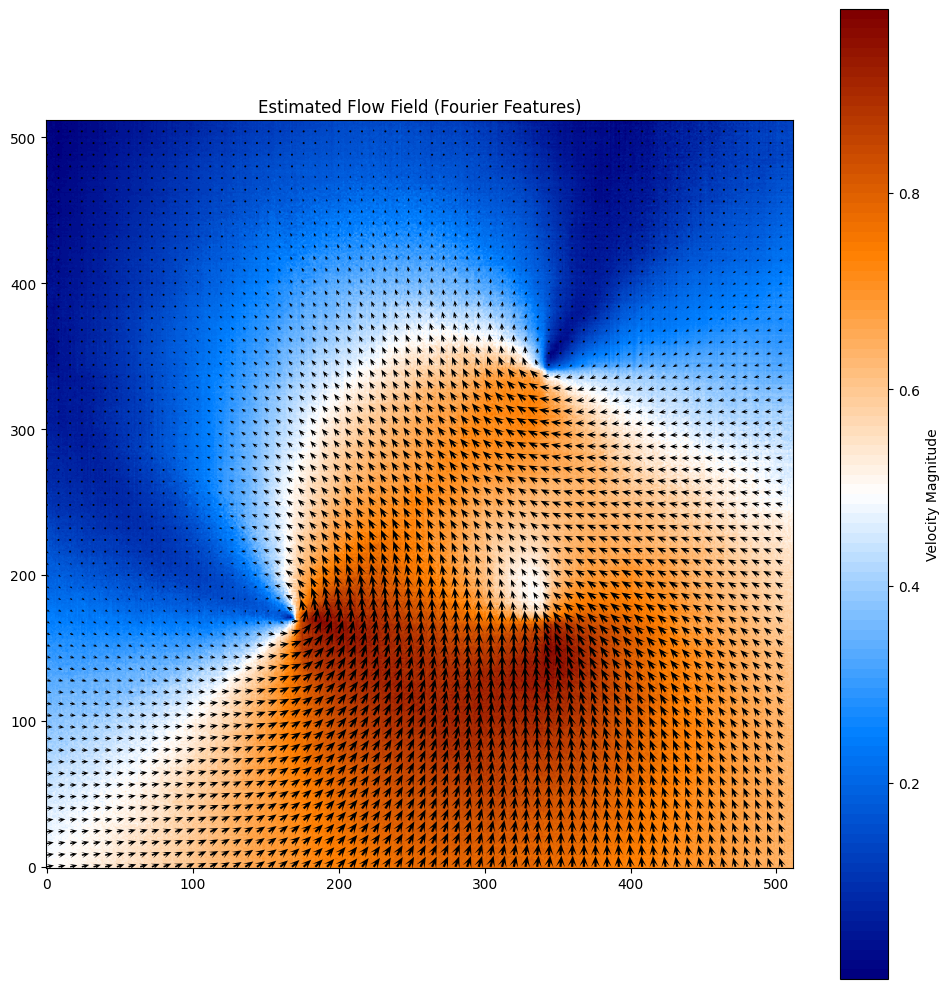

In [15]:
estimated_flow_ff = estimated_flow_tensor_ff.detach().cpu().numpy()
plot_flow_field(estimated_flow_ff, "Estimated Flow Field (Fourier Features)", SIZE // 8)

In [14]:
ode = FourierFeatureODE(2, (256 for _ in range(3)), num_fourier_features=126, random_features=True).to(device)
estimated_flow_tensor_rff = fit_flow_field(ode, flow_tensor, coordinate_tensor)

Epoch 1, Loss: 0.11448831856250763
Epoch 100, Loss: 0.01817963272333145
Epoch 200, Loss: 0.00789298489689827
Epoch 300, Loss: 0.005899237468838692
Epoch 400, Loss: 0.0046913232654333115
Epoch 500, Loss: 0.003604494035243988
Epoch 600, Loss: 0.002869876567274332
Epoch 700, Loss: 0.0024269046261906624
Epoch 800, Loss: 0.002045894507318735
Epoch 900, Loss: 0.0017722747288644314
Epoch 1000, Loss: 0.0015686985570937395
Epoch 2000, Loss: 0.0007607821607962251
Epoch 3000, Loss: 0.0005706374649889767
Epoch 4000, Loss: 0.0004967340501025319
Epoch 5000, Loss: 0.0004626511945389211
Epoch 6000, Loss: 0.00044588837772607803
Epoch 7000, Loss: 0.0004376122378744185
Epoch 8000, Loss: 0.00043368584010750055
Epoch 9000, Loss: 0.0004318944993428886
Epoch 10000, Loss: 0.0004311022930778563


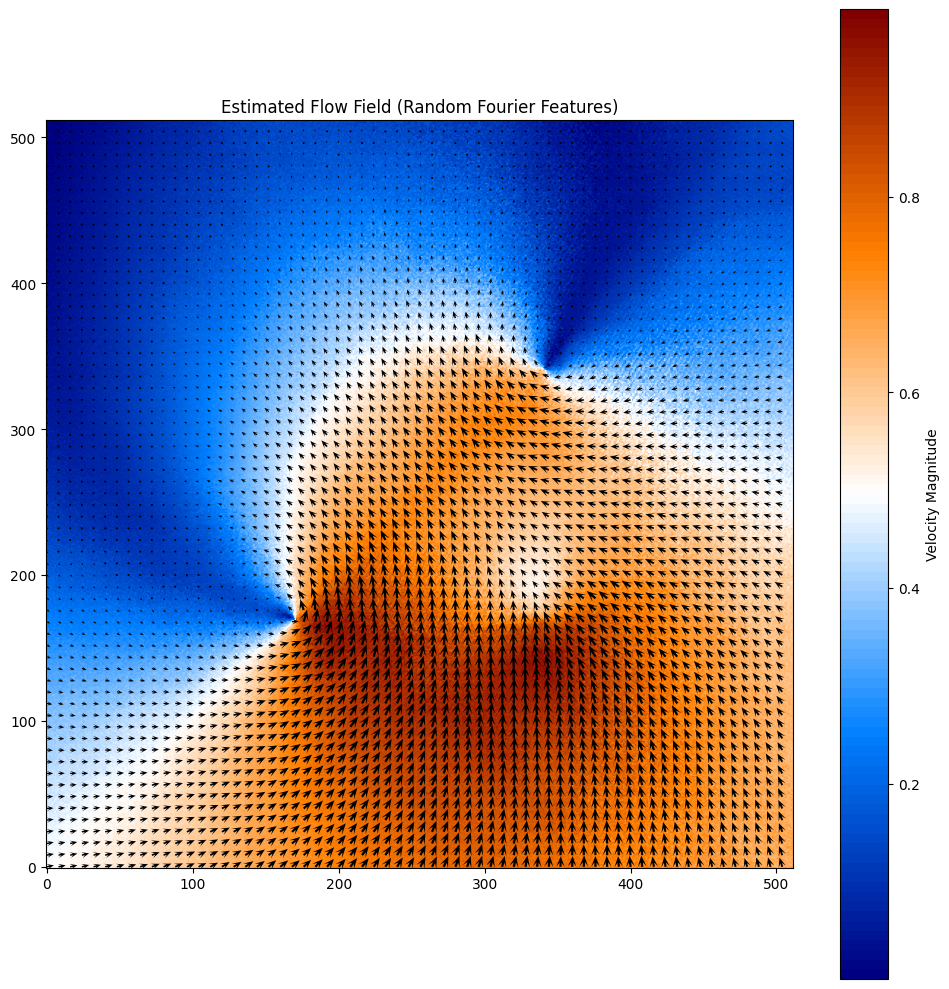

In [15]:
estimated_flow_rff = estimated_flow_tensor_rff.detach().cpu().numpy()
plot_flow_field(estimated_flow_rff, "Estimated Flow Field (Random Fourier Features)", SIZE // 8)

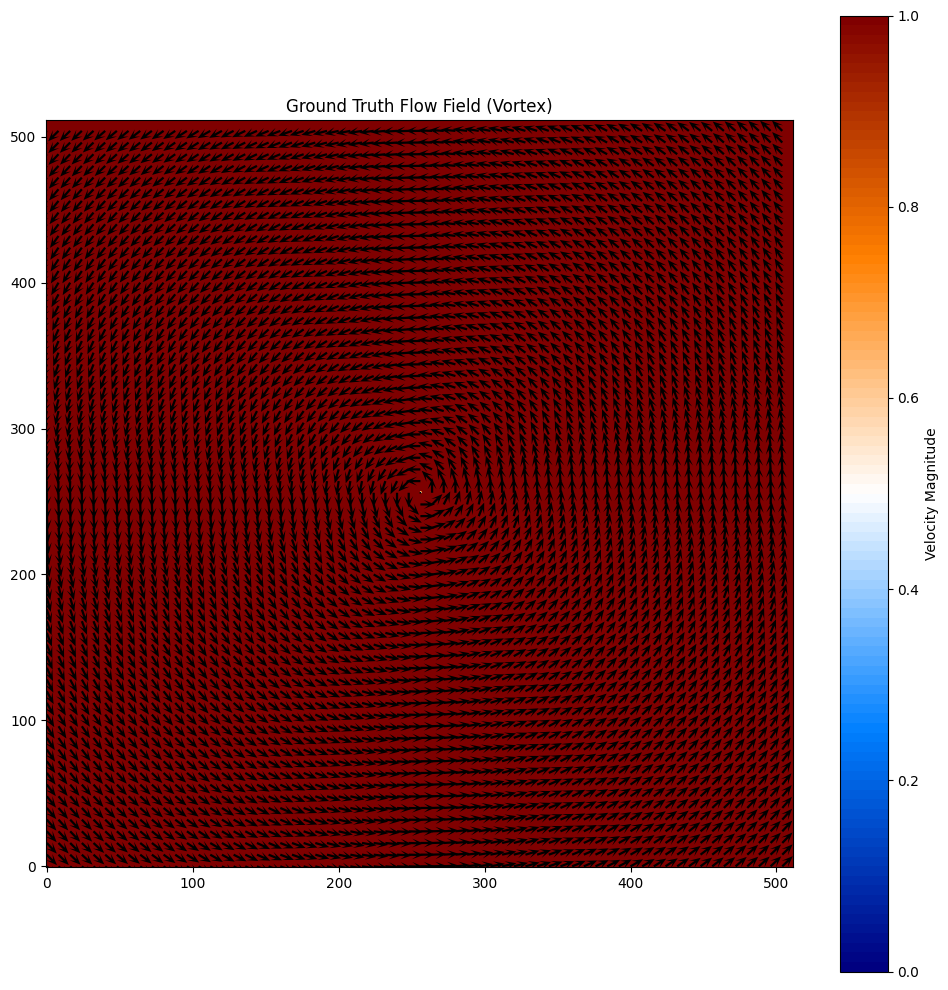

In [17]:
vortex_flow = generate_vortex_flow(SIZE)
plot_flow_field(vortex_flow, "Ground Truth Flow Field (Vortex)", SIZE // 8)

In [18]:
vortex_flow_tensor = torch.FloatTensor(vortex_flow)
vortex_flow_tensor = vortex_flow_tensor.to(device)
ode = ODE(2, (256 for _ in range(3))).to(device)
estimated_vortex_flow_tensor = fit_flow_field(ode, vortex_flow_tensor, coordinate_tensor)

Epoch 1, Loss: 21.23272705078125
Epoch 100, Loss: 0.19103708863258362
Epoch 200, Loss: 0.14050522446632385
Epoch 300, Loss: 0.07332317531108856
Epoch 400, Loss: 0.03704693168401718
Epoch 500, Loss: 0.03164060041308403
Epoch 600, Loss: 0.02812955714762211
Epoch 700, Loss: 0.026282763108611107
Epoch 800, Loss: 0.02469327487051487
Epoch 900, Loss: 0.022317267954349518
Epoch 1000, Loss: 0.019588423892855644
Epoch 2000, Loss: 0.01180831529200077
Epoch 3000, Loss: 0.009705292992293835
Epoch 4000, Loss: 0.00884256511926651
Epoch 5000, Loss: 0.008432670496404171
Epoch 6000, Loss: 0.008231831714510918
Epoch 7000, Loss: 0.008138742297887802
Epoch 8000, Loss: 0.008095404133200645
Epoch 9000, Loss: 0.008075693622231483
Epoch 10000, Loss: 0.008066811598837376


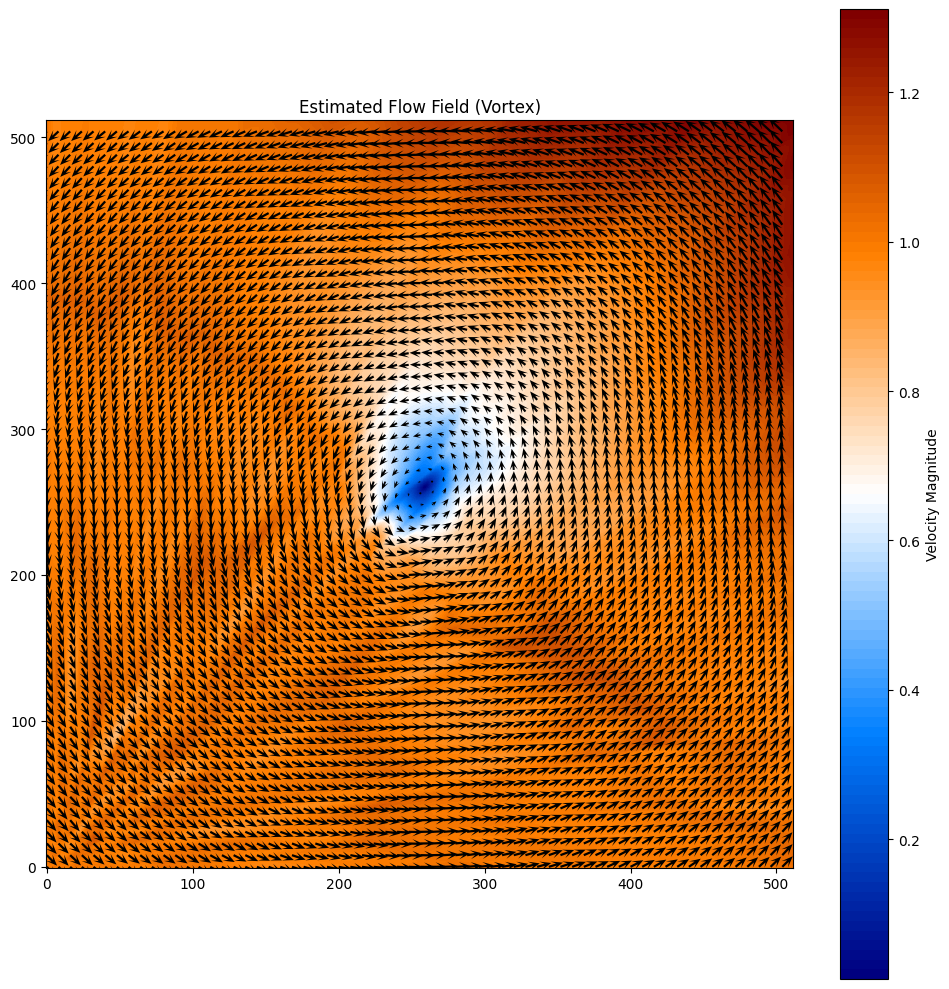

In [19]:
estimated_vortex_flow = estimated_vortex_flow_tensor.detach().cpu().numpy()
plot_flow_field(estimated_vortex_flow, "Estimated Flow Field (Vortex)", SIZE // 8)

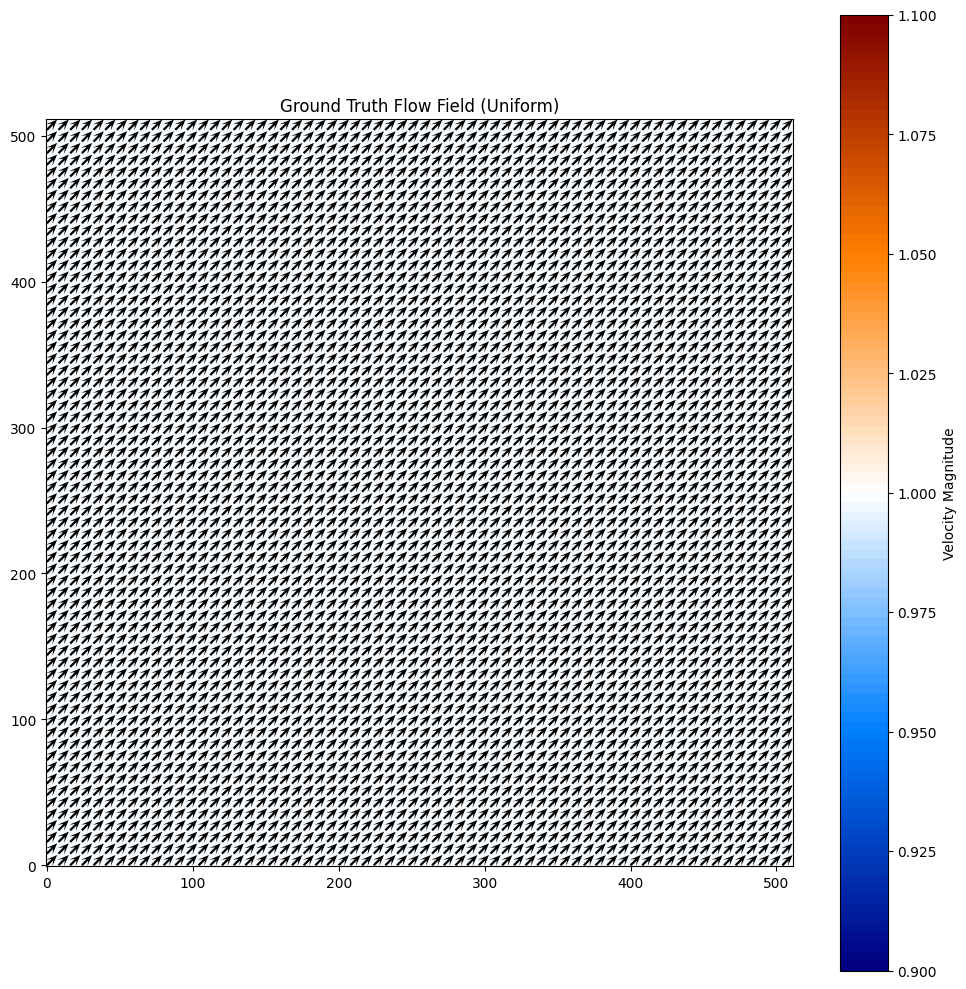

In [20]:
uniform_flow = generate_uniform_flow(SIZE)
plot_flow_field(uniform_flow, "Ground Truth Flow Field (Uniform)", SIZE // 8)

In [21]:
uniform_flow_tensor = torch.FloatTensor(uniform_flow)
uniform_flow_tensor = uniform_flow_tensor.to(device)
ode = ODE(2, (256 for _ in range(3))).to(device)
estimated_uniform_flow_tensor = fit_flow_field(ode, uniform_flow_tensor, coordinate_tensor)

Epoch 1, Loss: 13.274628639221191
Epoch 100, Loss: 0.056540459394454956
Epoch 200, Loss: 0.047900959849357605
Epoch 300, Loss: 0.023329466581344604
Epoch 400, Loss: 0.0016383087495341897
Epoch 500, Loss: 0.0005576544208452106
Epoch 600, Loss: 0.00031262217089533806
Epoch 700, Loss: 0.00024373327323701233
Epoch 800, Loss: 0.0001697664993116632
Epoch 900, Loss: 0.00013910955749452114
Epoch 1000, Loss: 0.00015030131908133626
Epoch 2000, Loss: 6.830077472841367e-05
Epoch 3000, Loss: 5.48169446119573e-05
Epoch 4000, Loss: 4.890579657512717e-05
Epoch 5000, Loss: 4.602343324222602e-05
Epoch 6000, Loss: 4.457035902305506e-05
Epoch 7000, Loss: 4.385077772894874e-05
Epoch 8000, Loss: 4.3506952351890504e-05
Epoch 9000, Loss: 4.333867764216848e-05
Epoch 10000, Loss: 4.325887857703492e-05


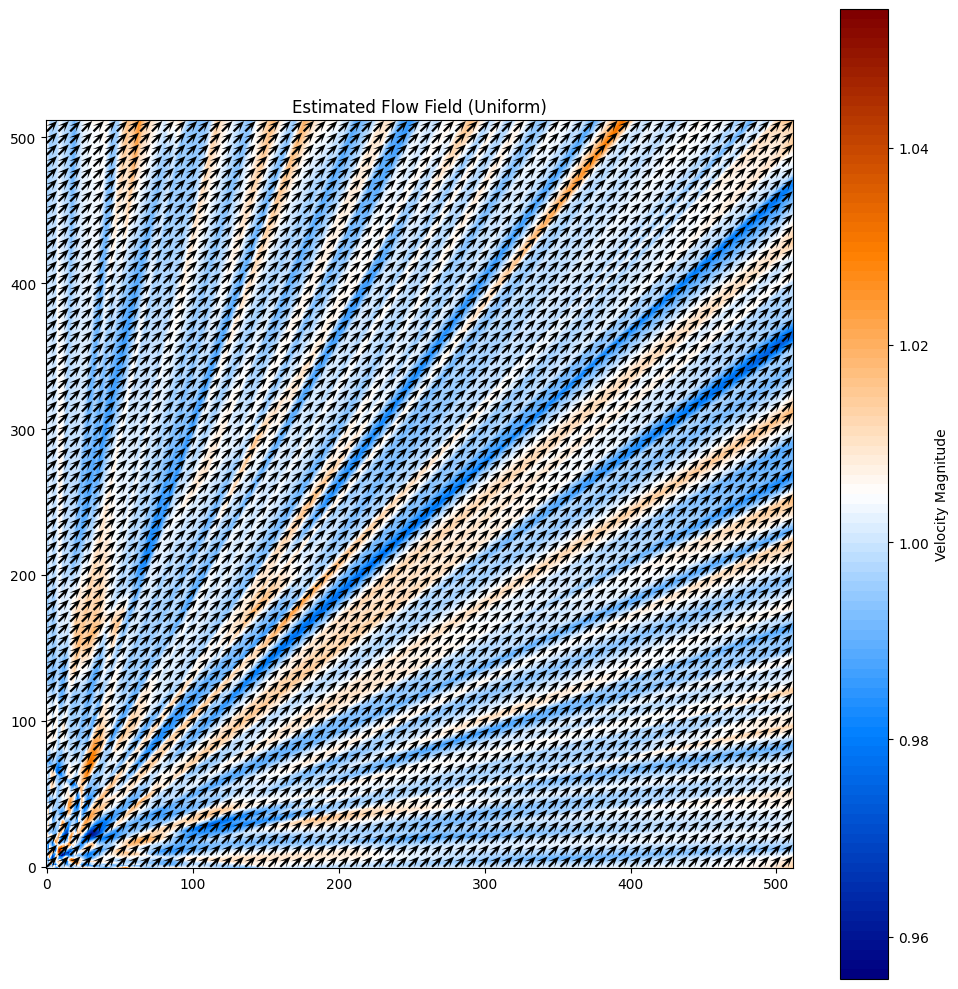

In [22]:
estimated_uniform_flow = estimated_uniform_flow_tensor.detach().cpu().numpy()
plot_flow_field(estimated_uniform_flow, "Estimated Flow Field (Uniform)", SIZE // 8)